# Accessing Planette's ERA5 Archive on AWS

This tutorial demonstrates how to access and analyze Planette's cloud-native ERA5 archive stored in Zarr format on AWS S3 using Python tools such as `xarray`, `zarr`, and `s3fs`. The data is chunked with [icechunk](https://github.com/earth-mover/icechunk) for efficient cloud-native access.


<img src="planette_icon.png" width=5000px height=150px />


## Prerequisites

Install the required packages if you haven't already:

```bash
pip install xarray zarr icechunk matplotlib s3fs
```


## 1. Import Libraries


In [3]:
import xarray as xr
import icechunk as ic
import matplotlib.pyplot as plt
import numpy as np

## 2. Define Zarr store path

The data is publicly accessible, so you do not need AWS credentials.


In [4]:
# get the bucket and prefix
variable = "sss"  # 2-meter temperature (K)
frequency = "day"  # daily means
bucket = "planettebaikal"
prefix = f"reanalysis/oras5/{variable}/{frequency}/0p25latx0p25lon/oras5_{variable}_{frequency}_0p25latx0p25lon.zarr"
print(prefix)

# get storage and repo for icechunk
storage = ic.s3_storage(bucket=bucket, prefix=prefix, from_env=True)
repo = ic.Repository.open(storage=storage)

# return readonly session
session = repo.readonly_session("main")

# open dataset
ds = xr.open_dataset(session.store, engine="zarr", consolidated=False, decode_timedelta=True, chunks={})


reanalysis/oras5/sss/day/0p25latx0p25lon/oras5_sss_day_0p25latx0p25lon.zarr


## 3. Get icechunk session and repo

Data is stored in Zarr format and is written with icechunk. To open data, you must use icechunk session and repo.


In [23]:
# get storage and repo for icechunk
storage = ic.s3_storage(bucket=bucket, prefix=prefix, from_env=True)
repo = ic.Repository.open(storage=storage)

# return readonly session
session = repo.readonly_session("main")

# open dataset
ds = xr.open_dataset(session.store, engine="zarr", consolidated=False, decode_timedelta=True, chunks={})

In [5]:
ds


<xarray.Dataset> Size: 103GB
Dimensions:  (lat: 721, time: 24685, lon: 1440)
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * time     (time) datetime64[ns] 197kB 1958-01-16 1958-01-17 ... 2025-08-16
  * lon      (lon) float64 12kB -179.8 -179.5 -179.2 ... 179.5 179.8 180.0
Data variables:
    sss      (time, lat, lon) float32 103GB dask.array<chunksize=(350, 361, 720), meta=np.ndarray>

## 4. Open the Dataset with Xarray

### Here are a few details about the data:
1. Data is organized by variable and temporal aggregation (daily, 7-day, 30-day, 90-day, monthly, 3-month)
2. Each variable has its own Zarr store
3. Data spans from 1940 to present
4. Global coverage at 0.25°×0.25° resolution
5. Data is chunked optimally for cloud access using icechunk


## 5. Basic Plot


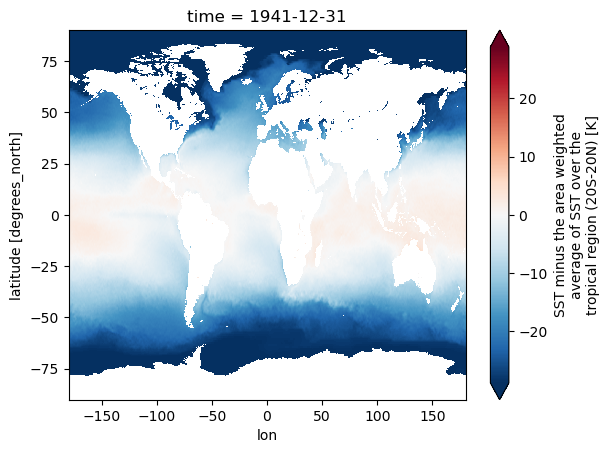

In [25]:
# Select a specific date and create a plot
t2m_20200101 = ds[f'{variable}'].isel(time=-1)
t2m_20200101.plot(cmap='RdBu_r', robust=True, extend='both')
plt.show()


## Conclusion

This tutorial demonstrated how to:
1. Access Planette's ERA5 archive using xarray and icechunk
2. Work with the daily mean version of ERA5
3. Analyze and visualize 2 meter temperature (t2m)
4. Plot the data

For more information about the dataset, please refer to the [README.md](README.md) file in this repository.

### Additional Resources
- [ERA5 Documentation](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation)
- [xarray Documentation](http://xarray.pydata.org/)
- [zarr Documentation](https://zarr.readthedocs.io/)
- [icechunk Documentation](https://github.com/earth-mover/icechunk)


In [1]:
import icechunk as ic
import xarray as xr
import icechunk.xarray 

# get the bucket and prefix
variable = "sss"  # 2-meter temperature (K)
frequency = "day"  # daily means
bucket = "planettebaikal"
branch = 'main'

# create session to write to
new_prefix = f"reanalysis/oras5/{variable}/{frequency}/0p25latx0p25lon/oras5_{variable}_{frequency}_0p25latx0p25lon.zarr"
new_storage = ic.s3_storage(bucket=bucket, prefix=new_prefix, from_env=True)
new_repo = ic.Repository.create(storage=new_storage)
new_session = new_repo.writable_session(branch=branch)

In [2]:

for year in range(1958, 1959):
    print(year)
    prefix = f"reanalysis/oras5/{variable}/{frequency}/0p25latx0p25lon/oras5_{variable}_{frequency}_0p25latx0p25lon_{year}.zarr"
    
    # get storage and repo for icechunk
    storage = ic.s3_storage(bucket=bucket, prefix=prefix, from_env=True)
    repo = ic.Repository.open(storage=storage)

    # return readonly session
    session = repo.readonly_session(branch=branch)

    # open dataset
    ds = xr.open_dataset(session.store, engine="zarr", consolidated=False, decode_timedelta=True)
    ds = ds.load()
    ds = ds.chunk({'time': 31, 'lat': -1, 'lon': -1})
    
    if year == 1958:
        ic.xarray.to_icechunk(ds, new_session, mode="w")
        new_session.commit('Initial write')
    else:
        # append data
        # create session to write to
        new_session = new_repo.writable_session(branch=branch)
        ic.xarray.to_icechunk(ds, new_session, mode="a",  append_dim='time')
        new_session.commit(f'Appending {year}')


1958


ValueError: Specified Zarr chunks encoding['chunks']=(350, 361, 720) for variable named 'sss' would overlap multiple Dask chunks. Check the chunk at position 1, which has a size of 31 on dimension 0. It is unaligned with backend chunks of size 350 in region slice(None, None, None). Writing this array in parallel with Dask could lead to corrupted data. To resolve this issue, consider one of the following options: - Rechunk the array using `chunk()`. - Modify or delete `encoding['chunks']`. - Set `safe_chunks=False`. - Enable automatic chunks alignment with `align_chunks=True`.